<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimental/ML_model(Resampling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install pandas-ta==0.2.45b

     |████████████████████████████████| 6.4 MB 39.9 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 88 kB 5.3 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-py3-none-any.whl size=175303 sha256=64e5a67223c2b364b03d518d4e7e19b9501bc49f1e5999ce01f6e97bc6f0ccf

In [2]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [123]:
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
import datetime as dt

In [1427]:
tickr='^nsei'
days_out=2
p_movement=4

In [1428]:
nifty = yf.download(tickr,start='2014-01-01',end='2018-12-31')

[*********************100%***********************]  1 of 1 completed


In [1429]:
nifty.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-27,10817.900391,10834.200195,10764.450195,10779.799805,10779.799805,456100
2018-12-28,10820.950195,10893.599609,10817.150391,10859.900391,10859.900391,245500


In [1430]:
nifty['close_2%']=np.abs(nifty['Adj Close'].pct_change()*100).fillna(0)

In [1431]:
test=pd.DataFrame(data=nifty['close_2%'].values,columns=['sum'])

In [1432]:
nifty['cumsum']=0
nifty=nifty.reset_index()

In [1433]:
for index , val in enumerate(nifty['close_2%']):
  
  if index==0:
    nifty.loc[index,'cumsum']=val
  else:
    if nifty['cumsum'].iloc[index-1]>p_movement:
      nifty.loc[index,'cumsum']=val
    else:
      nifty.loc[index, 'cumsum']=val+nifty['cumsum'].iloc[index-1]    

In [1434]:
#test_f=pd.DataFrame({'Date':nifty.index, 'sum':test['cumsum'].values})
#pd.DataFrame({'Date':df.index,'spread':(df['Adj Close'].values - mean)})

In [1435]:
nifty['diff']=nifty['close_2%']-nifty['cumsum']

In [1436]:
nifty[['Close','close_2%','cumsum','diff']]

,Close,close_2%,cumsum,diff
0,6221.149902,0.000000,0.000000,0.000000
1,6211.149902,0.160742,0.160742,0.000000
2,6191.450195,0.317167,0.477909,-0.160742
3,6162.250000,0.471621,0.949530,-0.477909
4,6174.600098,0.200415,1.149945,-0.949530
...,...,...,...,...
1215,10754.000000,1.805201,4.069973,-2.264772
1216,10663.500000,0.841547,0.841547,0.000000
1217,10729.849609,0.622212,1.463760,-0.841547
1218,10779.799805,0.465526,1.929285,-1.463760


In [1437]:
final_data=nifty.iloc[nifty[nifty['diff']==0].index-1][1:]

In [1438]:
final_data['Signal_Flag'] = final_data['Close'].transform(lambda x : np.sign(x.diff(days_out)))

In [1439]:
final_data=final_data.dropna()

In [1440]:
final_data.Signal_Flag.value_counts()

 1.0    98
-1.0    71
Name: Signal_Flag, dtype: int64

# Features Creation 

In [1441]:
final_data=final_data.reset_index(drop=True)

In [1442]:
final_data.ta.macd(append=True)
final_data.ta.vortex(append=True)
final_data.ta.aroon(append=True)
final_data.ta.mom(append=True)
final_data.ta.stdev(append=True)
final_data.ta.linreg(append=True)
final_data['spread']=final_data['LR_14']-final_data['close']
print()

In [1443]:
final_data['date']=final_data['date'].map(dt.datetime.toordinal)

In [1444]:
final_data=final_data.dropna()

In [1445]:
features=final_data.columns.tolist()

In [1446]:
features=[feats for feats in features if feats not in ['Signal_Flag']]

In [1447]:
X=final_data[features]
y=final_data['Signal_Flag']

In [1448]:
chk='Timeseries'

# and Modelling Part remaining

In [1449]:
from sklearn.model_selection import TimeSeriesSplit

if chk=='Block':
  tscv = BlockingTimeSeriesSplit(n_splits=10)

  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
elif chk=='Timeseries':
  tscv = TimeSeriesSplit(n_splits=15)
  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14


In [1450]:
for train_index, test_index in tscv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [1451]:
rand_frst_clf = RandomForestClassifier(n_estimators =220,max_depth=35,min_samples_leaf=14,max_features = "auto",min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)


In [1452]:
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, min_samples_leaf=14, min_samples_split=40,
                       n_estimators=220, random_state=42)

In [1453]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns
feature_imp

spread           0.305550
AROONU_14        0.126401
MOM_10           0.085073
MACDh_12_26_9    0.062916
VTXM_14          0.054749
VTXP_14          0.045471
AROOND_14        0.034092
high             0.024391
diff             0.024078
MACDs_12_26_9    0.024059
close_2%         0.022703
adj_close        0.022175
AROONOSC_14      0.021844
cumsum           0.020119
low              0.019778
LR_14            0.019029
MACD_12_26_9     0.017232
STDEV_30         0.016789
volume           0.015782
close            0.015356
date             0.013522
open             0.008891
dtype: float64

In [1454]:
#y_pd= rand_frst_clf.predict(X_train)

In [1455]:
# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [1456]:
timeseries=pd.concat([X_test['adj_close'].reset_index(),pd.Series(y_pred)],axis=1)

In [1457]:
timeseries.columns=['index','close','prediction']

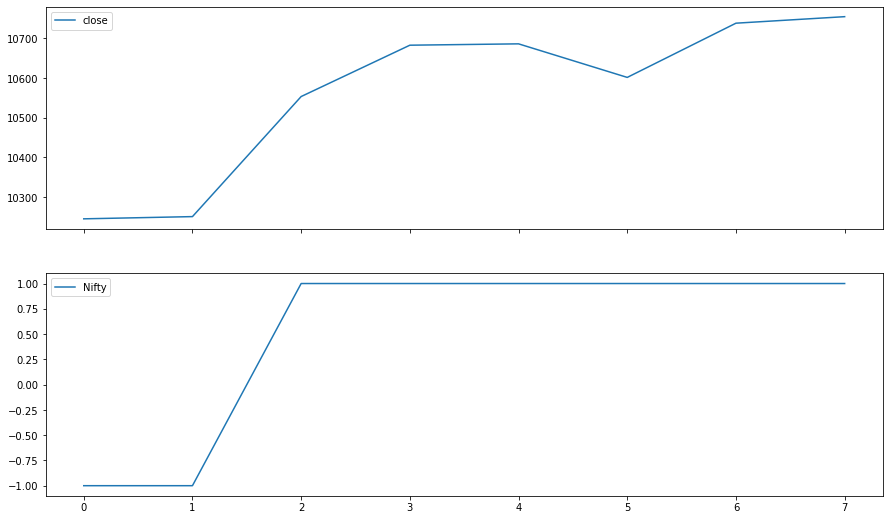

In [1458]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1, figsize=(15,9),sharex=True)
ax[0].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'close'], label='close')
ax[1].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'prediction'], label='Nifty')
ax[0].legend()
ax[1].legend()
plt.show()

In [1459]:
data_for_testing=yf.download(tickr,start='2019-01-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [1460]:
data_for_testing['Date']=data_for_testing['Date'].map(dt.datetime.toordinal)

In [1461]:
data_for_testing['close_2%']=np.abs(data_for_testing['Adj Close'].pct_change()*100).fillna(0)

In [1462]:
test_data=pd.DataFrame(data=data_for_testing['close_2%'].values,columns=['sum'])

In [1463]:
data_for_testing['cumsum']=0

In [1464]:
for index , val in enumerate(data_for_testing['close_2%']):
  
  if index==0:
    data_for_testing.loc[index,'cumsum']=val
  else:
    if data_for_testing['cumsum'].iloc[index-1]>p_movement:
      data_for_testing.loc[index,'cumsum']=val
    else:
      data_for_testing.loc[index, 'cumsum']=val+data_for_testing['cumsum'].iloc[index-1]

In [1465]:
data_for_testing['diff']=data_for_testing['close_2%']-data_for_testing['cumsum']

In [1466]:
final_test_data=data_for_testing.iloc[data_for_testing[data_for_testing['diff']==0].index-1][1:]

In [1467]:
final_test_data.ta.macd(append=True)
final_test_data.ta.vortex(append=True)
final_test_data.ta.aroon(append=True)
final_test_data.ta.mom(append=True)
final_test_data.ta.stdev(append=True)
final_test_data.ta.linreg(append=True)
final_test_data['spread']=final_test_data['LR_14']-final_test_data['close']
print()

In [1468]:
final_test_data['Signal_Flag'] = final_test_data['close'].transform(lambda x : np.sign(x.diff(days_out)))

In [1469]:
final_test_data=final_test_data.dropna()

In [1470]:
predict=rand_frst_clf.predict(final_test_data[features])

In [1471]:
timeseries=pd.concat([final_test_data['adj_close'].dropna()[-len(predict):].reset_index(),pd.Series(predict)],axis=1)

In [1472]:
timeseries.columns=['index','adj_close','predict']

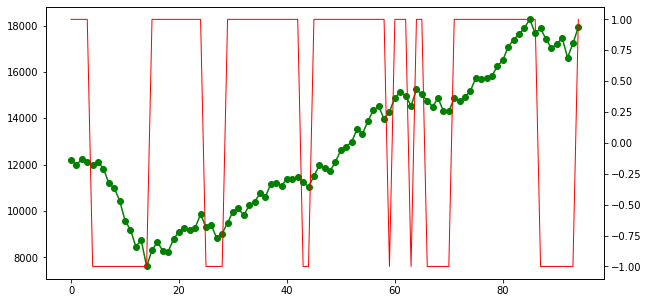

In [1473]:
fig, ax = plt.subplots(figsize=(10,5),sharex=True)
ax.plot(timeseries.loc[:, :].index, timeseries.loc[:, 'adj_close'], label='Nifty',color='g',marker='o')
ax2=ax.twinx()
ax2.plot(timeseries.loc[:, :].index, timeseries.loc[:, 'predict'], label='Prediction',color='r',linewidth=1)
plt.show()

In [1474]:
print('days out :', days_out)
print('percentage movement :',str(p_movement) + ' %')

days out : 2
percentage movement : 4 %


In [1477]:
data_for_testing.tail(8)

,Date,Open,High,Low,Close,Adj Close,Volume,close_2%,cumsum,diff
736,738154,17201.449219,17264.050781,17146.349609,17203.949219,17203.949219,320800,0.056063,0.170089,-0.114026
737,738155,17244.500000,17400.800781,17238.500000,17354.050781,17354.050781,167000,0.872483,1.042572,-0.170089
738,738158,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500,1.565332,2.607903,-1.042572
739,738159,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400,1.018687,3.626591,-2.607903
740,738160,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500,0.673959,4.300549,-3.626591
741,738161,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500,1.000542,1.000542,0.000000
742,738162,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300,0.376418,1.376960,-1.000542
743,738165,17913.300781,18017.449219,17879.150391,18003.300781,18003.300781,0,1.070032,2.446992,-1.376960


In [1476]:
final_test_data.tail(2)

,date,open,high,low,close,adj_close,volume,close_2%,cumsum,diff,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,VTXP_14,VTXM_14,AROOND_14,AROONU_14,AROONOSC_14,MOM_10,STDEV_30,LR_14,spread,Signal_Flag
734,738152,17177.599609,17250.250000,17161.150391,17233.25,17233.25,176000,0.860341,4.483322,-3.622981,685.626360,-159.932559,845.558919,0.828486,0.733787,0.0,42.857143,42.857143,-384.900391,1260.816069,17320.839166,87.589166,-1.0
740,738160,17820.099609,17944.699219,17748.849609,17925.25,17925.25,251500,0.673959,4.300549,-3.626591,699.680995,-116.702339,816.383334,0.835582,0.748952,0.0,35.714286,35.714286,30.050781,1287.483412,17350.025519,-575.224481,1.0


In [1478]:
if final_test_data['Signal_Flag'].iloc[-1]!=final_test_data['Signal_Flag'].iloc[-2]:
  date_triggered=final_test_data['date'].iloc[-1]

In [1488]:
date_trig=str(dt.datetime.fromordinal(date_triggered))

In [1503]:
date_trig

'2022-01-05 00:00:00'

In [1516]:
print(f'triggered on date : {int(date_trig[-11:-9])} and signal : {final_test_data["Signal_Flag"].iloc[-1]}')

triggered on date : 5 and signal : 1.0


In [ ]:
#2022-01-05 00:00:00